Compare Age
---

Age comparison plot similar to Gross et al 2019.

In [7]:
import xarray as xr
import pandas as pd
import stompy.model.data_comparison as dc
from stompy import utils
import stompy.plot.cmap as scmap
from stompy.grid import multi_ugrid
from stompy.spatial import proj_utils
import numpy as np
import os
import matplotlib.pyplot as plt
turbo=scmap.load_gradient('turbo.cpt')
%matplotlib notebook

In [8]:
# Load USGS data
data_dir="/home/rustyh/src/hybrid/data/usgs/20141001"

age_fn=os.path.join(data_dir,"Water_residence_time_data.xlsx")
age_df=pd.read_excel(age_fn).rename({'Timestamp':'time',
                                     'τ (days)':'tau_days',},axis=1)
age_df=age_df[ ~age_df['time'].isnull() ]

In [9]:
ll=age_df[ ['Longitude','Latitude'] ].values
xy=proj_utils.mapper('WGS84','EPSG:26910')(ll)
age_df['x']=xy[:,0]
age_df['y']=xy[:,1]

In [10]:
age_df.head(2)

,time,Latitude,Longitude,Boat Distance (mi),Boat Speed (mi/hr),WS fDOM (QSE),WS fCHLA (µg/L),C Tr (%),C 650 (m-1),NO3 (mg/L),...,EXO fCHLA (µg/L),EXO fBGAPC (µg/L),δ2H (per mil),δ18O (per mil),E/I,E/I 1σ,tau_days,τ 1σ,x,y
0,2014-10-01 10:34:34,38.2466,-121.68741,0.00605,19.37024,10.36,3.33,57.454295,40.509703,0.65,...,2.12,0.44,-75.94,-10.13,0.04905,0.000289,8.564911,2.214090,614857.294620,4.233991e+06
1,2014-10-01 10:35:05,38.2490,-121.68730,0.00608,19.46432,10.53,3.32,57.769041,40.564521,0.65,...,2.03,0.44,-75.90,-10.09,0.04970,0.000288,8.911129,2.243596,614863.142625,4.234257e+06


In [113]:
# Get map output around the time of the cruise
#run_dirs=['/opt2/csc/dflowfm/runs/age2014_v01']
run_dirs=['runs/age2014_v02']

import six
six.moves.reload_module(multi_ugrid)

mus=[ multi_ugrid.MultiUgrid(os.path.join(d,'DFM_OUTPUT_flowfm','flowfm_*_map.nc')) for d in run_dirs]

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

In [114]:
def extract_cruise(ds_map,grid,cell_dim,cruise,fields=None):
    """
    ds_map: xr.Dataset with per-cell output
    grid: UnstructuredGrid object
    cell_dim: name of the dimension in ds_map that corresponds to 
      horizontal cells.
    cruise: data to match, a pd.DataFrame with x,y, and time fields.
    fields: list of field names to include.
    """
    t_cruise=cruise['time'].values  

    if fields is None:
        #fields=ds_map.data_vars
        raise Exception("Not implemented. Specify fields explicitly")

    # will populate a dataset per sample point then concatenate afterwards
    samples=[None]*len(cruise)

    cruise_xy=np.c_[cruise.x,cruise.y]
    # Match cruise sample with a cell, using
    # cells_nearest to allow for samples not falling exactly within a
    # cell
    cells=grid.points_to_cells(cruise_xy, method='cells_nearest')        

    #tidxs=np.searchsorted(ds_map.time.values,t_cruise)
    tidxs=utils.nearest(ds_map.time.values,t_cruise)
    for tidx,idxs in utils.enumerate_groups(tidxs):
        t_map=ds_map.time.values[tidx]
        for idx in idxs:
            samples[idx]=ds_map[ fields ].isel(**{cell_dim:cells[idx],'time':tidx})

    extracted=xr.concat(samples,dim='sample')
    extracted['time_offset']=('sample',),extracted['time']-t_cruise
    extracted['time_offset_h']=('sample',),extracted['time_offset']/np.timedelta64(1,'s')/3600.
    return extracted

<IPython.core.display.Javascript object>


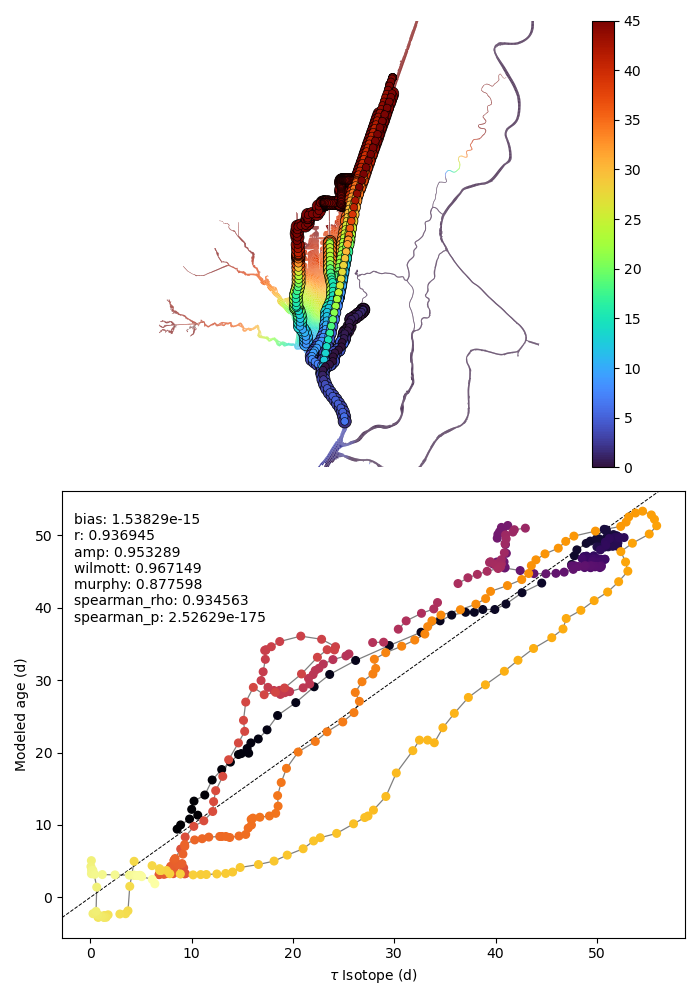

Map time error: -0.12 to 0.12 hours


In [156]:
# both the run and the data should be in PST
fig,axss=plt.subplots(2,len(mus),squeeze=False,figsize=(7,10))
axs=axss[0,:]
axscats=axss[1,:]

clim=[0,45]
halo=True # scatter outer ring with modeled age.

def calc_age(ds,cmin=1e-6):
    # .values b/c multi_ugrid not that smart
    return np.where(ds['mesh2d_RcNit'].values>cmin,
                    ds['mesh2d_NO3'].values / ds['mesh2d_RcNit'].values.clip(cmin),
                    np.nan)
    
for ax,axscat,mu in zip(axs,axscats,mus):
    scat=ax.scatter(age_df.x, age_df.y, 30,age_df.tau_days,cmap=turbo,zorder=2,
                    ec='k',lw=0.4)
    mod=extract_cruise(mu,grid=mu.grid,cell_dim='mesh2d_nFaces',
                       cruise=age_df,fields=['mesh2d_NO3','mesh2d_RcNit'])
    print("Map time error: %.2f to %.2f hours"%(mod['time_offset_h'].min(),
                                                mod['time_offset_h'].max()))
    mod['age']=('sample',),calc_age(mod)
    # sel=np.isfinite(mod['age'].values)    
    #age_xy=np.c_[age_df.x,age_df.y]
    #age_ref=np.argmin(age_df.tau_days)
    #age_ref_xy=age_xy[age_ref]
    
    offset=offset_days=float((mod.age - age_df.tau_days).mean())

    if halo:
        scat2=ax.scatter(age_df.x,age_df.y,90,mod['age']-offset,
                         cmap=turbo,zorder=1.5,ec='k',lw=0.5)
        scat2.set_clim(clim)
        
    # When bringing in error metrics, probably better to fit overall,
    # in case there is substantial error at the reference point
    #cells=mu.grid.points_to_cells(age_xy, method='cells_nearest')
    t_cruise=age_df['time'].values  
    # Load a snapshot around the start of the cruise for a background.
    tidx=np.searchsorted(mu.time,t_cruise[0])
    snap=mu.isel(time=tidx)
    snap_age=calc_age(snap)
    
    ccoll=mu.grid.plot_cells(values=snap_age-offset,
                             cmap=turbo,ax=ax)
    plt.setp([ccoll,scat],clim=clim)
    ax.axis('equal')
    ax.axis('off')
    plt.colorbar(ccoll,ax=ax,orientation='vertical')
    ax.axis((599410.1696215905, 631017.7729131989, 4226915.966264306, 4255155.546254349))
    
    # And the scatter:
    axscat.plot(age_df.tau_days, mod['age']-offset, lw=0.9,color='k',alpha=0.5,
                zorder=0)
    axscat.scatter(age_df.tau_days, mod['age']-offset, 30, age_df.time-age_df.time.min(),
                   cmap='inferno')
    
    axscat.axline([0,0],[1,1],color='k',ls='--',lw=0.7,zorder=0)
    axscat.set_xlabel(r'$\tau$ Isotope (d)')
    axscat.set_ylabel('Modeled age (d)')
    metrics=dc.calc_metrics( age_df.tau_days.values, mod['age'].values-offset )
    axscat.text(0.02,0.95,
               "\n".join([f"{k}: {metrics[k]:3g}" for k in metrics]),
                transform=axscat.transAxes,va='top')

    fig.tight_layout()
# 

In [119]:
# How is the phasing of age?
# A few test locations:
locs=[ [616525,4240986], # near N end of run up liberty cut
       [617674,4240521], # near 2 samples in DWS
       [617374,4240580], # toe drain
]

mu=mus[0]

mod_ages=[]

for loc in locs:
    # time series from map files:
    cell=mu.grid.select_cells_nearest(loc)
    mu_cell=mu.isel(mesh2d_nFaces=cell)
    age=calc_age(mu_cell)
    mod_ages.append( xr.DataArray(age,dims=['time'],coords={'time':mu_cell.time}))

INFO:multi_ugrid:Dropping mesh2d_node_z because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping mesh2d_edge_nodes because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping mesh2d_edge_faces because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping mesh2d_edge_type because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping mesh2d_u1 because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping mesh2d_u0 because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping mesh2d_q1 because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping mesh2d_viu because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping mesh2d_diu because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping mesh2d_node_z because it has unselected partitioned dimensions
INFO:multi_ugrid:Dropping mesh2d_edge_nodes because it has unselected partitioned dimensions
INFO:multi_ugrid:Droppin

<IPython.core.display.Javascript object>


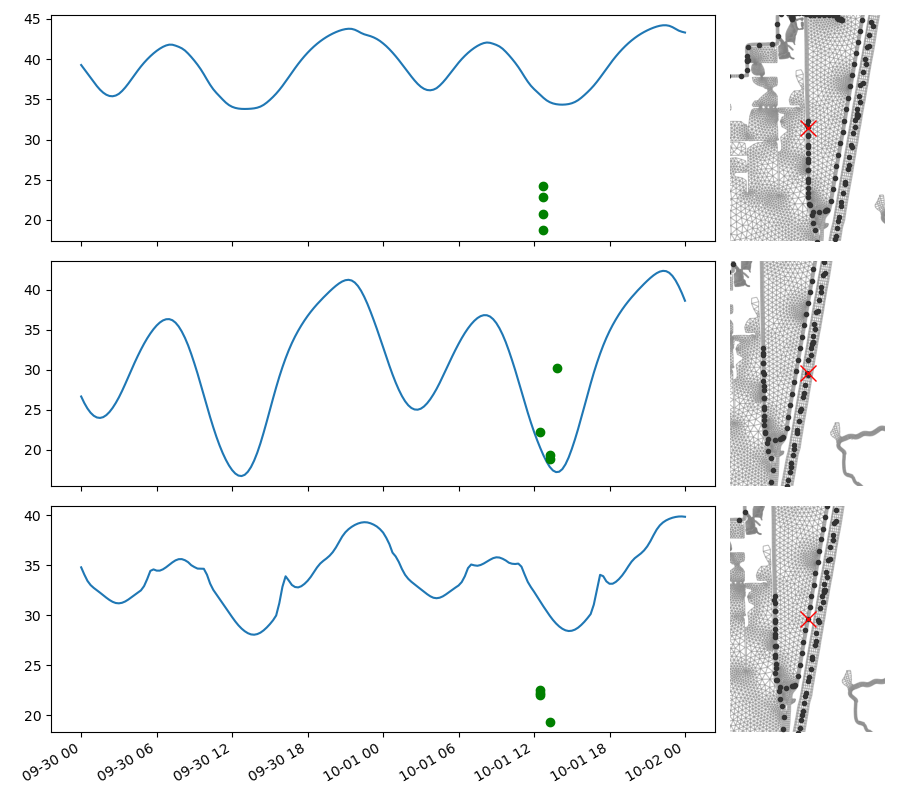

In [145]:
from matplotlib import gridspec
G=gridspec.GridSpec(len(locs),5)

fig=plt.figure(figsize=(9,8))

age_xy=age_df[ ['x','y']].values

zoom=[age_xy[:,0].min(), age_xy[:,0].max(),
      age_xy[:,1].min(), age_xy[:,1].max()]

N=4 # closest N samples
for i,(mod_age,loc) in enumerate(zip(mod_ages,locs)):
    ax=fig.add_subplot(G[i,:-1])
    ax.plot(mod_age.time, mod_age-offset)
    matches=np.argsort(utils.dist(age_xy,loc))[:N]
    ax.plot(age_df.time.values[matches],
            age_df.tau_days.values[matches],'go')
    ax_map=fig.add_subplot(G[i,-1])
    ax_map.plot(age_df.x,age_df.y,'.',color='0.2')
    ax_map.plot([loc[0]],[loc[1]],'rx',ms=12)
    ax_map.axis('equal')
    mu.grid.plot_edges(ax=ax_map,clip=zoom,color='0.5',alpha=0.5)
    ax_map.axis('off')
    pad=2000
    ax_map.axis([loc[0]-pad,loc[0]+pad,loc[1]-pad,loc[1]+pad])
    
fig.autofmt_xdate()
fig.tight_layout()

In [162]:
poly=mu.grid.boundary_polygon()
from stompy.plot import plot_wkb

INFO:join_features:0 open strings, 61 simple polygons
INFO:join_features:Building index
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=211033317.314454, 60 potential interiors


<IPython.core.display.Javascript object>


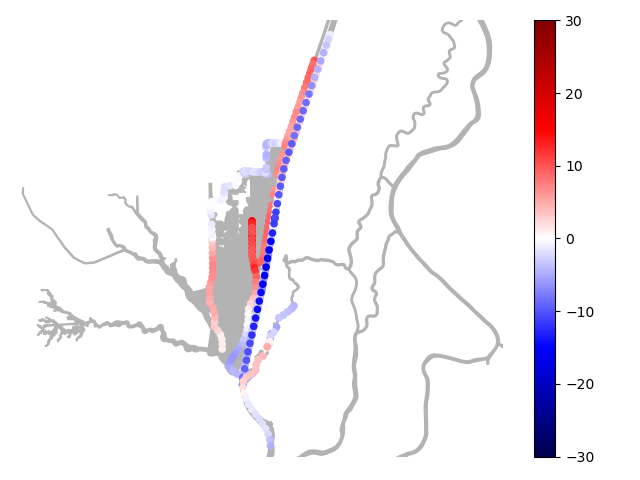

In [168]:
# mimic the error plot in Gross 2019
fig,ax=plt.subplots()
plot_wkb.plot_wkb(poly,ax=ax,fc='0.7',ec='0.7',zorder=-1)

scat=plt.scatter(age_df.x, age_df.y, 20, mod['age']-offset-age_df.tau_days)
scat.set_cmap('seismic')
scat.set_clim([-30,30])
plt.colorbar(scat)
zoom=(603807.8871592418, 630032.8700288354, 4227968.26795684, 4252395.570549083)
plt.axis('tight')
plt.axis('equal')
plt.axis('off')
plt.axis(zoom)
fig.tight_layout()

In [166]:
plt.axis()

(603807.8871592418, 630032.8700288354, 4227968.26795684, 4252395.570549083)